**Imports**

In [1]:
import os
import glob
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from monai.transforms import (
    Compose, LoadImageD, EnsureChannelFirstD, ScaleIntensityRangeD, RandRotateD,
    RandFlipD, ToTensorD
)
from monai.data import Dataset, DataLoader, CacheDataset
import monai
from PIL import Image
import nibabel as nib
import pandas as pd
import torch
from matplotlib.colors import ListedColormap
from tqdm import tqdm
import cv2
from monai.transforms import Transform

#!pip install nibabel

C:\Users\gijsd\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


**Data Collection**

First we collect all the filepaths.

In [2]:
testing_path = '../data/testing/'
training_path = '../data/training/'

def get_acdc_file_paths(data_path):
    original_images = glob.glob(os.path.join(data_path, 'patient*/patient*_frame??.nii.gz'))
    gt_images = glob.glob(os.path.join(data_path, 'patient*/patient*_frame??_gt.nii.gz'))

    return original_images, gt_images

training_original_images, training_gt_images = get_acdc_file_paths(training_path)
testing_original_images, testing_gt_images = get_acdc_file_paths(testing_path)

print("Training Original Images:", len(training_original_images))
print("Training GT Images:", len(training_gt_images))
print("Testing Original Images:", len(testing_original_images))
print("Testing GT Images:", len(testing_gt_images))

Training Original Images: 200
Training GT Images: 200
Testing Original Images: 100
Testing GT Images: 100


Then we create a dataframe to store all metadata

In [3]:
# Create a dataframe to store the patient number, frame number, the file path of the image, gt file path and whether it is a training or testing image

def parse_info_file(info_file_path):
    info_dict = {}
    with open(info_file_path, 'r') as file:
        for line in file:
            key, value = line.strip().split(': ')
            info_dict[key] = value if key == 'Group' else float(value) if '.' in value else int(value)
    return info_dict

def get_acdc_file_paths(data_paths):
    data_records = []
    
    for data_path, dataset_type in data_paths:
        # Get all the image and ground truth file paths
        image_pattern = os.path.join(data_path, 'patient*/patient*_frame??.nii.gz')
        gt_pattern = os.path.join(data_path, 'patient*/patient*_frame??_gt.nii.gz')
        image_paths = glob.glob(image_pattern)
        gt_paths = glob.glob(gt_pattern)

        # Convert gt_paths to a dictionary for quick lookup
        gt_dict = {os.path.basename(gt_path).replace('_gt', ''): gt_path for gt_path in gt_paths}

        for image_path in image_paths:
            basename = os.path.basename(image_path)
            patient_number = basename.split('_')[0].replace('patient', '')
            frame_number = basename.split('_')[1].replace('frame', '').replace('.nii.gz', '')

            # Extracting the directory path to read the info.cfg
            patient_dir = os.path.dirname(image_path)
            info_file_path = os.path.join(patient_dir, 'info.cfg')
            patient_info = parse_info_file(info_file_path)

            gt_path = gt_dict.get(basename, None)

            data_records.append({
                'patient_number': patient_number,
                'frame_number': frame_number,
                'image_path': image_path,
                'gt_path': gt_path,
                'dataset_type': dataset_type,
                **patient_info  # Add the info.cfg data to the record
            })

    # Create a DataFrame
    df = pd.DataFrame(data_records)

    return df

training_path = '../data/Training'
testing_path = '../data/Testing'

# Call the function with both paths and their dataset types
data_paths = [(training_path, 'Training'), (testing_path, 'Testing')]
df_metadata = get_acdc_file_paths(data_paths)

# Count the number of entries of each dataset type
counts = df_metadata['dataset_type'].value_counts()
print(counts)

df_metadata.head(10)
#print(df_metadata.columns)

dataset_type
Training    200
Testing     100
Name: count, dtype: int64
Index(['patient_number', 'frame_number', 'image_path', 'gt_path',
       'dataset_type', 'ED', 'ES', 'Group', 'Height', 'NbFrame', 'Weight'],
      dtype='object')


In [4]:
df_metadata.head(10)

,patient_number,frame_number,image_path,gt_path,dataset_type,ED,ES,Group,Height,NbFrame,Weight
0,001,01,../data/Training\patient001\patient001_frame01...,../data/Training\patient001\patient001_frame01...,Training,1,12,DCM,184.0,30,95.0
1,001,12,../data/Training\patient001\patient001_frame12...,../data/Training\patient001\patient001_frame12...,Training,1,12,DCM,184.0,30,95.0
2,002,01,../data/Training\patient002\patient002_frame01...,../data/Training\patient002\patient002_frame01...,Training,1,12,DCM,160.0,30,70.0
3,002,12,../data/Training\patient002\patient002_frame12...,../data/Training\patient002\patient002_frame12...,Training,1,12,DCM,160.0,30,70.0
4,003,01,../data/Training\patient003\patient003_frame01...,../data/Training\patient003\patient003_frame01...,Training,1,15,DCM,165.0,30,77.0
5,003,15,../data/Training\patient003\patient003_frame15...,../data/Training\patient003\patient003_frame15...,Training,1,15,DCM,165.0,30,77.0
6,004,01,../data/Training\patient004\patient004_frame01...,../data/Training\patient004\patient004_frame01...,Training,1,15,DCM,159.0,28,46.0
7,004,15,../data/Training\patient004\patient004_frame15...,../data/Training\patient004\patient004_frame15...,Training,1,15,DCM,159.0,28,46.0
8,005,01,../data/Training\patient005\patient005_frame01...,../data/Training\patient005\patient005_frame01...,Training,1,13,DCM,165.0,30,77.0
9,005,13,../data/Training\patient005\patient005_frame13...,../data/Training\patient005\patient005_frame13...,Training,1,13,DCM,165.0,30,77.0


In [5]:
# Split the DataFrame into training and testing sets
train_df = df_metadata[df_metadata['dataset_type'] == 'Training']
test_df = df_metadata[df_metadata['dataset_type'] == 'Testing']

# Convert 3D images to 2D slices
def create_slices_dict(df):
    slices_dict = []
    for _, row in df.iterrows():
        image = nib.load(row['image_path']).get_fdata()
        label = nib.load(row['gt_path']).get_fdata()

        for i in range(image.shape[-1]):  # Iterate over the slices
            slice_image = image[:, :, i]
            slice_label = label[:, :, i]
            meta_dict = {
                'affine': np.eye(4),
                'spatial_shape': slice_image.shape,
                'original_channel_dim': -1,
                'slice_number': i
            }
            # Add DataFrame row information to the metadata
            for col in df.columns:
                meta_dict[col] = row[col]

            slices_dict.append({'image': slice_image, 'label': slice_label, 'img_meta_dict': meta_dict, 'mask_meta_dict': meta_dict})
    return slices_dict

training_slices_dict = create_slices_dict(train_df)
testing_slices_dict = create_slices_dict(test_df)

# Define custom transform to load data
class LoadData(Transform):
    def __init__(self, keys=None):
        pass

    def __call__(self, sample):
        image = sample['image']
        mask = sample['label']

        return {'image': image, 'label': mask, 'img_meta_dict': sample['img_meta_dict'], 'mask_meta_dict': sample['mask_meta_dict']}

# training_files_dict = [{'image': row['image_path'], 'label': row['gt_path']} for _, row in train_df.iterrows()]
# testing_files_dict = [{'image': row['image_path'], 'label': row['gt_path']} for _, row in test_df.iterrows()]
# 
# class LoadDataFromPath(monai.transforms.Transform):
#     def __init__(self, keys=None):
#         pass
# 
#     def __call__(self, sample):
#         image = nib.load(sample['image']).get_fdata() # Image has values that differ a lot, so we need to normalise
#         mask = nib.load(sample['label']).get_fdata()# Has unique values 0, 1, 2, 3
#         
#         # TODO: Add any label processing if needed
#         # TODO: Add metadata to the sample, like from the df
#         return {'image': image, 'label': mask, 'img_meta_dict': {'affine': np.eye(4)},
#                 'mask_meta_dict': {'affine': np.eye(4)}}

{'image': array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0., 18., 30., ...,  2.,  2.,  2.],
       [ 0., 19., 30., ...,  2.,  2.,  2.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]]), 'label': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), 'img_meta_dict': {'affine': array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]]), 'spatial_shape': (216, 256), 'original_channel_dim': -1, 'slice_number': 0, 'patient_number': '001', 'frame_number': '01', 'image_path': '../data/Training\\patient001\\patient001_frame01.nii.gz', 'gt_path': '../data/Training\\patient001\\patient001_frame01_gt.nii.gz', 'dataset_type': 'Training', 'ED': 1, 'ES': 12, 'Group': 'DCM',

**Investigate distribution of intensity values and apply histogram equalization**

Computing histogram: 100%|██████████| 200/200 [00:02<00:00, 95.57it/s] 


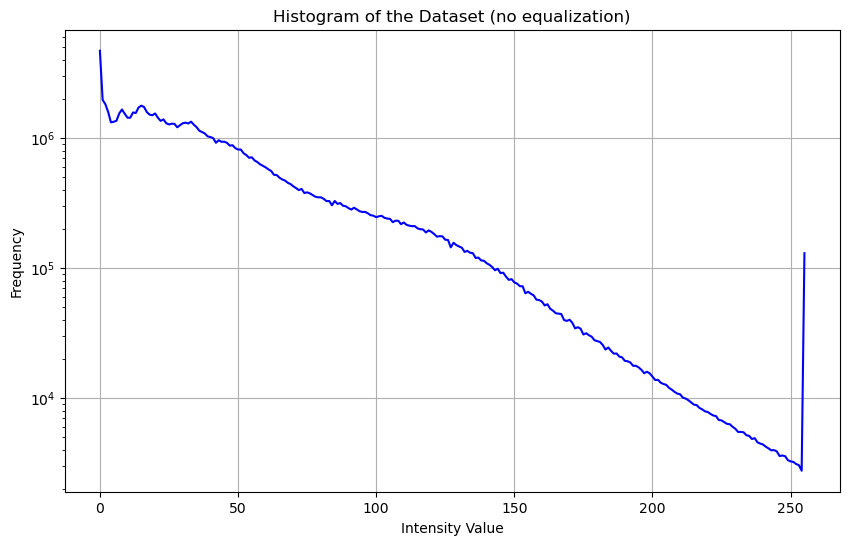

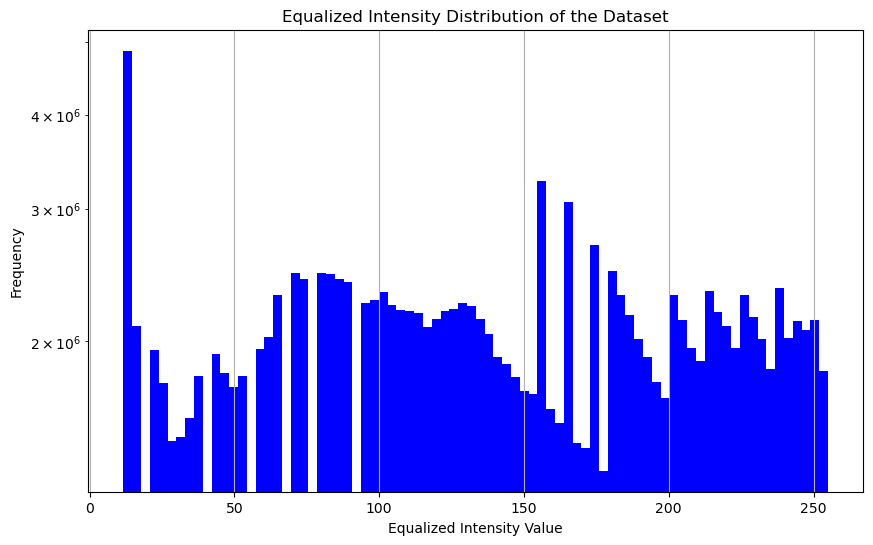

In [11]:
def compute_histogram_and_cdf(df):
    hist = np.zeros(256)

    for image_path in tqdm(df['image_path'], desc="Computing histogram"):
        image = nib.load(image_path).get_fdata()
        image = (image / np.max(image) * 255).astype(np.uint8)  # Normalize to [0, 255]
        hist += np.histogram(image, bins=256, range=(0, 256))[0]

    cdf = hist.cumsum()
    cdf_normalized = cdf * (255 / cdf[-1])  # Normalize CDF to [0, 255]

    return hist, cdf_normalized

# Function to apply histogram equalization using the CDF
def apply_histogram_equalization(image, cdf):
    image = (image / np.max(image) * 255).astype(np.uint8)  # Normalize to [0, 255]
    equalized_image = cdf[image]
    return equalized_image

# Apply histogram equalization to all images and collect intensity values for visualization
def collect_equalized_intensity_values(df, cdf):
    intensity_values = []

    for image_path in tqdm(df['image_path'], desc="Collecting equalized values"):
        image = nib.load(image_path).get_fdata()
        equalized_image = apply_histogram_equalization(image, cdf)
        intensity_values.extend(equalized_image.flatten())

    return np.array(intensity_values)

# Compute the histogram and CDF of the entire training dataset
hist, cdf = compute_histogram_and_cdf(df_metadata[df_metadata['dataset_type'] == 'Training']) # Note, we only use the training dataset because we don't want to leak information from the testing dataset

# Show the histogram, before equalization
plt.figure(figsize=(10, 6))
plt.plot(hist, color='blue')
plt.title('Histogram of the Dataset (no equalization)')
plt.xlabel('Intensity Value')
plt.ylabel('Frequency')
plt.yscale('log')
plt.grid(True)
plt.show()

# Collect equalized intensity values from the DataFrame
equalized_intensity_values = collect_equalized_intensity_values(df_metadata, cdf)

#TODO: remove spikes?

# Plot the histogram of equalized intensity values
plt.figure(figsize=(10, 6))
plt.hist(equalized_intensity_values, bins=80, color='blue')
plt.title('Equalized Intensity Distribution of the Dataset')
plt.xlabel('Equalized Intensity Value')
plt.ylabel('Frequency')
plt.yscale('log')
plt.grid(True)
plt.show()


In [12]:
# Define custom transforms
class HistogramEqualization(monai.transforms.Transform):
    def __init__(self, cdf):
        self.cdf = cdf

    def __call__(self, sample):
        image = sample['image']
        image = (image / np.max(image) * 255).astype(np.uint8)  # Normalize to [0, 255]
        equalized_image = self.cdf[image]
        sample['image'] = equalized_image
        return sample

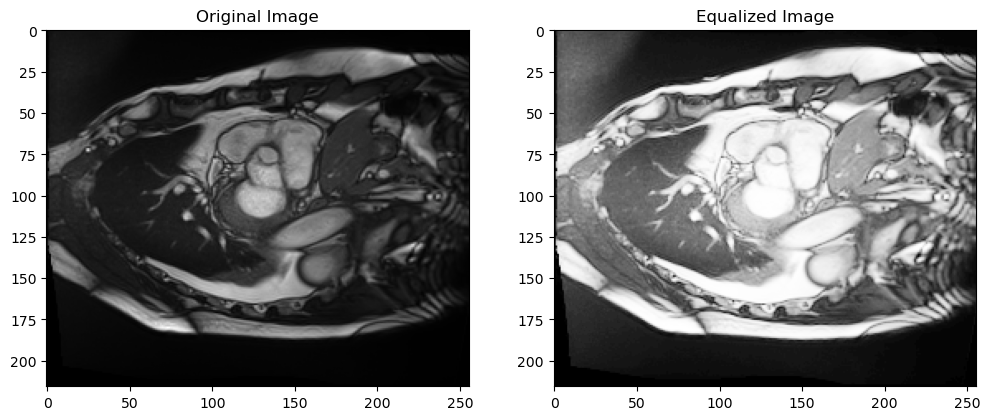

In [13]:
# Test the transformation on a single image and visualize it
sample_image = training_slices_dict[0]['image']
transform_test = HistogramEqualization(cdf)
equalized_sample_image = transform_test({'image': sample_image})['image']

# Display the original and equalized images
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(sample_image, cmap='gray')
plt.title('Original Image')
plt.subplot(1, 2, 2)
plt.imshow(equalized_sample_image, cmap='gray')
plt.title('Equalized Image')
plt.show()

In [14]:
size_y = 150
size_x = 150

# TODO: probably change which transforms to take
# TODO: create separate transforms for training and testing
composed_transforms = monai.transforms.Compose([
    LoadData(keys=['image', 'label']),
    HistogramEqualization(cdf=cdf),
    monai.transforms.EnsureChannelFirstD(keys=['image', 'label'], channel_dim='no_channel'),    
    monai.transforms.RandRotateD(keys=['image', 'label'], range_x=15, prob=0.5),
    monai.transforms.RandFlipD(keys=['image', 'label'], spatial_axis=0, prob=0.5),
    monai.transforms.RandSpatialCropd(keys=['image', 'label'], roi_size=[size_x, size_y], random_size=False),
    monai.transforms.ToTensorD(keys=['image', 'label'])
])

# Prepare the dataset and dataloader
train_dataset = Dataset(data=training_slices_dict, transform=composed_transforms)
test_dataset = Dataset(data=testing_slices_dict, transform=composed_transforms)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)



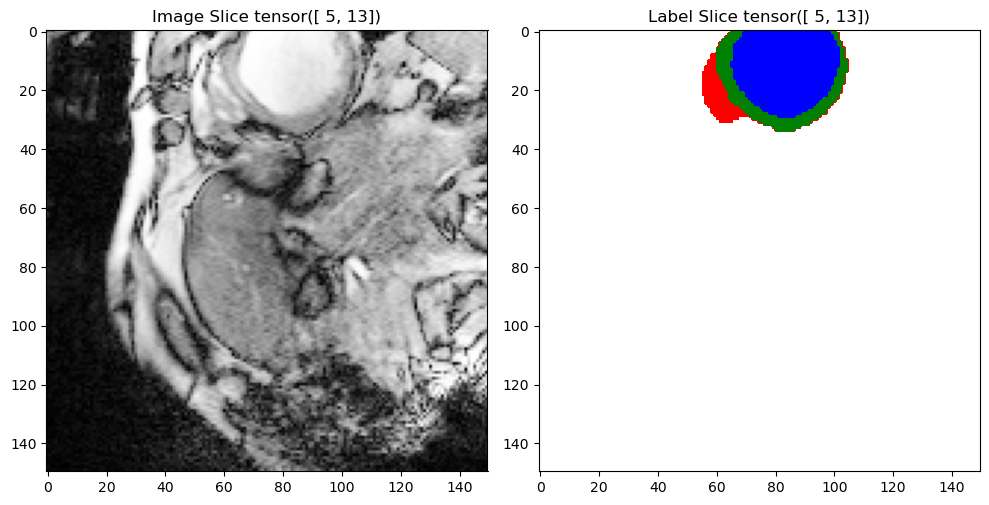

In [23]:
label_cmap = ListedColormap(['none', 'red', 'green', 'blue'])

def visualize_single_sample(data_loader):
    data = next(iter(data_loader))
    image, label = data['image'][0], data['label'][0]
    slice_number = data['img_meta_dict']['slice_number']
    #TODO: fix metadata, because slicenumber should not be two numbers...
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(image[0].numpy(), cmap="gray")
    axes[0].set_title(f"Image Slice {slice_number}")
    axes[1].imshow(label[0].numpy(), cmap=label_cmap)
    axes[1].set_title(f"Label Slice {slice_number}")
    plt.tight_layout()
    plt.show()

# Visualize a single sample from the training loader
visualize_single_sample(train_loader)